In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [1]:
import pandas as pd
from preprocess.discretization import discretization, get_nodes_type, code_categories, get_nodes_sign
from bayesian.train_bn import structure_learning, parameter_learning
from bayesian.calculate_accuracy import calculate_acc
#from block_learning.partial_bn_train import connect_partial_bn, hierarchical_train, direct_connect, direct_train, range_pairs
import seaborn as sns
import numpy as np
from copy import  copy
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from bayesian.sampling import generate_synthetics
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN, draw_comparative_hist
import networkx as nx
from pomegranate import log_probability, BayesianNetwork
from external.libpgm.sampleaggregator import SampleAggregator
import operator
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [2]:
vk_data = pd.read_csv('../data/vk_data.csv')
vk_data.head(10)

,sex,age,city_id,has_high_education,relation,num_of_relatives,followers_count,status,mobile_phone,twitter,...,"car, cars, sale, tires","sale, clothes, size, price, sewing","ingredients, cooking, dishes, salt, spices","theater, performance, actors","photographer, photography, show, wedding, photographer",top1_interes,top2_interes,top3_interes,top4_interes,top5_interes
0,1,50.0,2,0,0,2,27,0,0,0,...,0.201622,3.397819e-02,0.003674,0.308135,0.010700,"theater, performance, actors","car, cars, sale, tires","participation, festival, exhibition","client, project, internet, business, company","home, renovation, decoration, installation"
1,2,36.0,2,0,0,2,6,0,0,0,...,0.060985,2.529792e-02,0.020964,0.011533,0.003497,"book, reading, language, word, literature","music, concerts, rock, tickets, festivals","school, education, question, topic","client, project, internet, business, company","war, history, army, politics"
2,1,65.0,2,0,0,2,25,0,0,0,...,0.000009,2.007164e-09,0.100547,0.001567,0.049170,"client, project, internet, business, company","skin, face, care, cosmitology","ingredients, cooking, dishes, salt, spices","treatment, doctors, tests, clinic, health","photographer, photography, show, wedding, phot..."
3,2,30.0,2,0,0,2,52,0,1,0,...,0.143803,5.324164e-03,0.027627,0.014820,0.019036,"war, history, army, politics","car, cars, sale, tires","film, series, cinema, genre","music, concerts, rock, tickets, festivals","football, match, russia, team, goalkeeper"
4,2,36.0,2,0,0,2,18,0,0,0,...,0.037360,4.527913e-02,0.087596,0.043889,0.072074,"home, renovation, decoration, installation","ingredients, cooking, dishes, salt, spices","game, team, competition, sport","massage, meditation, yoga","shop, price, gifts, internet"
5,2,22.0,2,1,0,10,167,0,0,0,...,0.025479,1.996316e-02,0.010990,0.033827,0.035163,"music, concerts, rock, tickets, festivals","client, project, internet, business, company","school, education, question, topic","participation, festival, exhibition","film, series, cinema, genre"
6,2,23.0,2,0,0,2,275,1,0,0,...,0.073340,1.916149e-02,0.007811,0.019288,0.023399,"film, series, cinema, genre","car, cars, sale, tires","game, team, competition, sport","participation, festival, exhibition","music, concerts, rock, tickets, festivals"
7,1,27.0,2,0,0,2,475,0,0,0,...,0.005444,5.542228e-02,0.099362,0.061058,0.041686,"film, series, cinema, genre","ingredients, cooking, dishes, salt, spices","participation, festival, exhibition","dress, fashion, color, style","book, reading, language, word, literature"
8,2,25.0,2,0,0,2,37,0,0,0,...,0.052164,1.516378e-02,0.001627,0.020647,0.021668,"music, concerts, rock, tickets, festivals","film, series, cinema, genre","game, team, competition, sport","beauty, hair, manicure, salon","vacation, sea, accommodation, cost"
9,2,35.0,2,0,0,2,41,0,0,0,...,0.056157,5.284686e-02,0.011395,0.032997,0.020119,"home, renovation, decoration, installation","war, history, army, politics","participation, festival, exhibition","film, series, cinema, genre","car, cars, sale, tires"


In [3]:
vk_data = vk_data[['age', 'sex', 'has_high_education', 'relation', 'top1_interes', 'top2_interes', 'top3_interes', 'is_parent', 'has_pets', 'mean_tr', 'median_tr', 'tr_per_month']]
vk_data.columns = ['age', 'sex', 'has_high_education', 'relation', 'top1_interest', 'top2_interest', 'top3_interest', 'is_parent', 'has_pets', 'mean_tr', 'median_tr', 'tr_per_month']
vk_data['sex'] = vk_data['sex'].apply(lambda x: str(x))
vk_data['has_high_education'] = vk_data['has_high_education'].apply(lambda x: str(x))
vk_data['relation'] = vk_data['relation'].apply(lambda x: str(x))
vk_data['is_parent'] = vk_data['is_parent'].apply(lambda x: str(x))
vk_data['has_pets'] = vk_data['has_pets'].apply(lambda x: str(x))
vk_data.dropna(inplace=True)
vk_data.reset_index(inplace=True, drop=True)

In [4]:
node_types = get_nodes_type(vk_data)
node_types

{'age': 'cont',
 'sex': 'disc',
 'has_high_education': 'disc',
 'relation': 'disc',
 'top1_interest': 'disc',
 'top2_interest': 'disc',
 'top3_interest': 'disc',
 'is_parent': 'disc',
 'has_pets': 'disc',
 'mean_tr': 'cont',
 'median_tr': 'cont',
 'tr_per_month': 'cont'}

In [5]:
nodes_sign = get_nodes_sign(vk_data)
nodes_sign

{'age': 'pos', 'mean_tr': 'pos', 'median_tr': 'pos', 'tr_per_month': 'pos'}

In [60]:
# train, test = train_test_split(vk_data, test_size=0.01)
test = vk_data.sample(500)
#train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

In [6]:
coded_data, coder = code_categories(vk_data, 'label', ['sex', 'has_high_education', 'relation','top1_interest','top2_interest','top3_interest', 'is_parent', 'has_pets'])

In [7]:
discrete, est = discretization(coded_data, 'equal_frequency', bins= 5, columns=['age', 'mean_tr', 'median_tr', 'tr_per_month'])

In [69]:
algs = ['K2', 'MI', 'BIC', 'LL']
acc_df = pd.DataFrame(columns=['Parameter', 'Score', 'Accuracy'])
rmse_df = pd.DataFrame(columns=['Parameter', 'Score', 'RMSE'])
for alg in algs:
    bn = structure_learning(discrete, 'HC', node_types, alg)
    param = parameter_learning(vk_data, node_types, bn, method='simple')
    save_structure(bn, 'K2_bn_structure')
    skel = read_structure('K2_bn_structure')
    save_params(param, 'K2_bn_param')
    params = read_params('K2_bn_param')
    full = HyBayesianNetwork(skel, params)
    acc, rmse, real, pred, indexes = calculate_acc(full, test, vk_data.columns.tolist(), 'simple')
    for key in acc.keys():
        acc_df = acc_df.append({'Parameter': key, 'Score': alg, 'Accuracy': 1 - acc[key]}, ignore_index=True)
    for key in rmse.keys():
        rmse_df = rmse_df.append({'Parameter': key, 'Score': alg, 'RMSE': rmse[key]}, ignore_index=True)

In [72]:
acc_df.groupby('Score')['Accuracy'].mean()

Score
BIC    0.535000
K2     0.515000
LL     0.525000
MI     0.526667
Name: Accuracy, dtype: float64

In [71]:
rmse_df

,Parameter,Score,RMSE
0,age,K2,0.17
1,age,MI,0.18
2,age,BIC,0.17
3,age,LL,0.18


<BarContainer object of 4 artists>

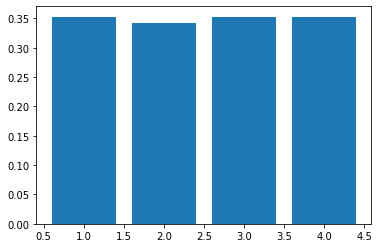

In [74]:
mean_error = [0.3525, 0.3425, 0.3525, 0.353]
x = [1, 2, 3, 4]
plt.bar(x, mean_error)

In [8]:
bn = structure_learning(coded_data, 'HC', node_types, 'MI')
param = parameter_learning(vk_data, node_types, bn, method='simple')

c:\Users\anaxa\Documents\Projects\Synthetic avatar\Synthetic_scripts\BN-based synthetic data\experiments\bayesian\redef_HC.py:156: RuntimeWarning: overflow encountered in double_scalars
  delta_score = nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Synthetic avatar\Synthetic_scripts\BN-based synthetic data\experiments\bayesian\redef_HC.py:224: RuntimeWarning: overflow encountered in double_scalars
  delta1 = -1* nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Synthetic avatar\Synthetic_scripts\BN-based synthetic data\experiments\bayesian\redef_HC.py:236: RuntimeWarning: overflow encountered in double_scalars
  delta2 = nrow * (mi_old - mi_new)


In [24]:
save_structure(bn, 'K2_bn_structure')
skel = read_structure('K2_bn_structure')
save_params(param, 'K2_bn_param')
params = read_params('K2_bn_param')
full = HyBayesianNetwork(skel, params)

In [28]:
sample = generate_synthetics(full, nodes_sign, 'simple', 10000)

C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


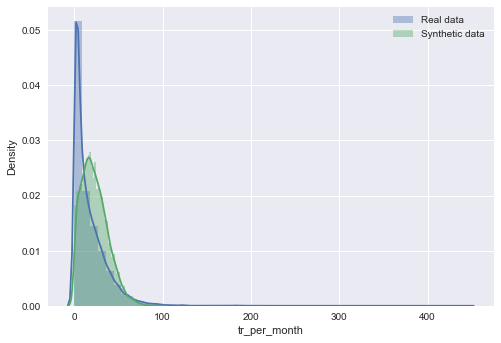

In [29]:
import matplotlib.style
import matplotlib as mpl
mpl.style.use('seaborn')
sns.distplot(vk_data['tr_per_month'], label='Real data')
sns.distplot(sample['tr_per_month'], label='Synthetic data')
plt.legend()
#sns.heatmap(coded_data.corr())

In [26]:
sample['top1_interest'] = sample['top1_interest'].apply(lambda x: coder['top1_interest'][x])
sample['top2_interest'] = sample['top2_interest'].apply(lambda x: coder['top2_interest'][x])
sample['top3_interest'] = sample['top3_interest'].apply(lambda x: coder['top3_interest'][x])
sample['sex'] = sample['sex'].apply(lambda x: coder['sex'][x])
sample['has_high_education'] = sample['has_high_education'].apply(lambda x: coder['has_high_education'][x])
sample['relation'] = sample['relation'].apply(lambda x: coder['relation'][x])
sample['is_parent'] = sample['is_parent'].apply(lambda x: coder['is_parent'][x])
sample['has_pets'] = sample['has_pets'].apply(lambda x: coder['has_pets'][x])
sample = sample[['age', 'sex', 'has_high_education', 'relation', 'top1_interest', 'top2_interest', 'top3_interest', 'is_parent', 'has_pets', 'mean_tr', 'median_tr', 'tr_per_month']]

<AxesSubplot:>

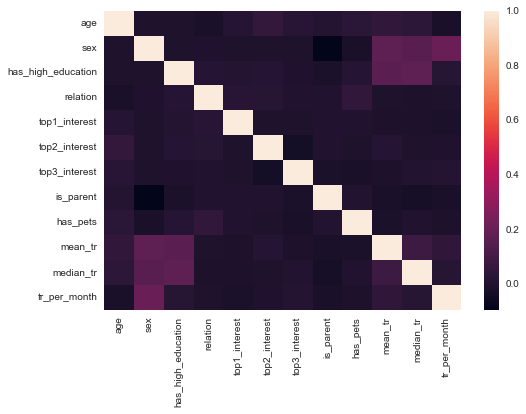

In [27]:
sns.heatmap(sample.corr())

In [25]:
sample_relation = vk_data.loc[vk_data['sex'] == 1]

In [27]:
bn_relation_samle = generate_synthetics(full, nodes_sign, 'simple', 13900, evidence={'sex': '1'})

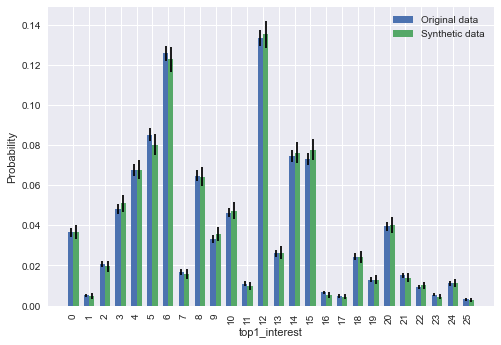

In [20]:
draw_comparative_hist('top1_interest', vk_data, sample, node_types)

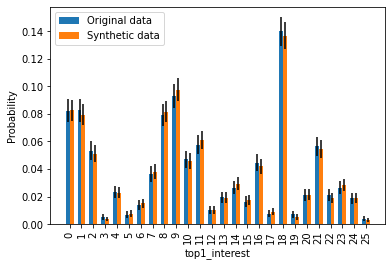

In [19]:
draw_comparative_hist('top1_interest', sample_relation, bn_relation_samle, node_types)
#plt.xticks([i for i in range (1,27,1)], [i for i in range (1,27,1)])

In [32]:
coder['top3_interest']

{'beauty, hair, manicure, salon': 0,
 'book, reading, language, word, literature': 1,
 'car, cars, sale, tires': 2,
 'client, project, internet, business, company': 3,
 'color, flowers, interior, design': 4,
 'dress, fashion, color, style': 5,
 'film, series, cinema, genre': 6,
 'football, match, russia, team, goalkeeper': 7,
 'game, team, competition, sport': 8,
 'handmade, materials, products': 9,
 'home, renovation, decoration, installation': 10,
 'ingredients, cooking, dishes, salt, spices': 11,
 'iphone, apple, technology, equipment, smartphone': 12,
 'massage, meditation, yoga': 13,
 'music, concerts, rock, tickets, festivals': 14,
 'participation, festival, exhibition': 15,
 'photographer, photography, show, wedding, photographer': 16,
 'sale, clothes, size, price, sewing': 17,
 'school, education, question, topic': 18,
 'shop, price, gifts, internet': 19,
 'skin, face, care, cosmitology': 20,
 'theater, performance, actors': 21,
 'treatment, doctors, tests, clinic, health': 22,

In [20]:
sample_relation['sex'] = sample_relation['sex'].apply(lambda x: str(x))
bn_relation_samle['sex'] = bn_relation_samle['sex'].apply(lambda x: str(x))

<ipython-input-20-39a005f0b6db>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_relation['sex'] = sample_relation['sex'].apply(lambda x: str(x))


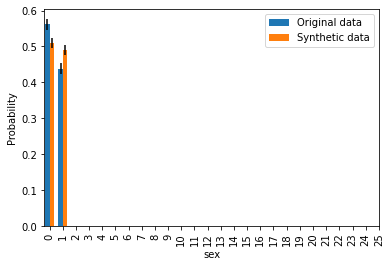

In [21]:
draw_comparative_hist('sex', sample_relation, bn_relation_samle, node_types)

In [36]:
sample = generate_synthetics(full, nodes_sign, 'simple', 30000)

In [12]:
vk_data['sex'] = vk_data['sex'].apply(lambda x: str(x))
sample['sex'] = sample['sex'].apply(lambda x: str(x))
vk_data['has_high_education'] = vk_data['has_high_education'].apply(lambda x: str(x))
sample['has_high_education'] = sample['has_high_education'].apply(lambda x: str(x))
vk_data['relation'] = vk_data['relation'].apply(lambda x: str(x))
sample['relation'] = sample['relation'].apply(lambda x: str(x))

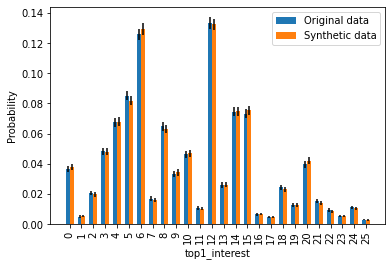

([<matplotlib.axis.XTick at 0x25cd40a90d0>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23'),
  Text(24, 0, '24'),
  Text(25, 0, '25'),
  Text(26, 0, '26')])

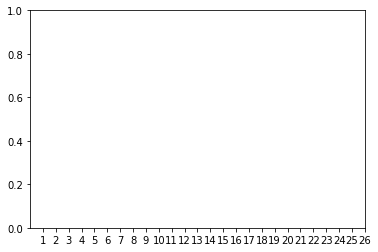

In [13]:
draw_comparative_hist('top1_interest', vk_data, sample, node_types)
plt.xticks([i for i in range (1,27,1)], [i for i in range (1,27,1)])

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

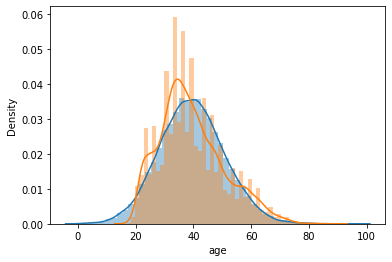

In [14]:
sns.distplot(sample['age'])
sns.distplot(vk_data['age'])

<AxesSubplot:>

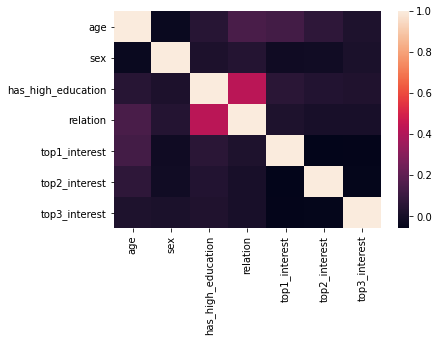

In [21]:
sns.heatmap(coded_data.corr())

In [23]:
sample['sex'] = sample['sex'].apply(lambda x: int(x))
sample['has_high_education'] = sample['has_high_education'].apply(lambda x: int(x))
sample['relation'] = sample['relation'].apply(lambda x: int(x))

In [47]:
sample['top1_interest'] = sample['top1_interest'].apply(lambda x: coder['top1_interest'][x])

In [48]:
sample['top2_interest'] = sample['top2_interest'].apply(lambda x: coder['top2_interest'][x])

In [49]:
sample['top3_interest'] = sample['top3_interest'].apply(lambda x: coder['top3_interest'][x])

In [50]:
sample = sample[['age', 'sex', 'has_high_education', 'relation', 'top1_interest', 'top2_interest', 'top3_interest']]

<AxesSubplot:>

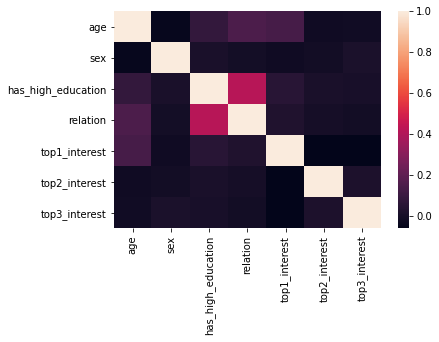

In [32]:
sns.heatmap(sample.corr())

In [56]:
real = copy(coded_data)
real['flag'] = [1 for _ in range(real.shape[0])]

In [53]:
sample['flag'] = [0 for _ in range(sample.shape[0])]

In [39]:
sample = sample[['age', 'sex', 'has_high_education', 'relation', 'top1_interest', 'top2_interest', 'top3_interest', 'flag']]

In [57]:
all_data = pd.concat([real, sample])

In [58]:
train, test = train_test_split(all_data, test_size=0.3)

In [59]:
train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

In [60]:
clf = LogisticRegression().fit(train[['age', 'sex', 'has_high_education', 'relation', 'top1_interest', 'top2_interest', 'top3_interest']].values, train['flag'].values)

In [64]:
clf.predict_proba(test[['age', 'sex', 'has_high_education', 'relation', 'top1_interest', 'top2_interest', 'top3_interest']].values)

array([[0.50562673, 0.49437327],
       [0.48995196, 0.51004804],
       [0.49420562, 0.50579438],
       ...,
       [0.50570955, 0.49429045],
       [0.50498524, 0.49501476],
       [0.49416192, 0.50583808]])

In [65]:
roc_auc_score(test['flag'].values, clf.predict_proba(test[['age', 'sex', 'has_high_education', 'relation', 'top1_interest', 'top2_interest', 'top3_interest']].values)[:, 1])

0.4938361496886874